In [99]:
import sys
from pathlib import Path

# assume this notebook lives in notebooks/, so parent() is the repo root
sys.path.append(str(Path().resolve().parent))
from paths import PROJECT_ROOT

In [100]:
import time
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# DreaMS
from dreams.utils.data import MSData
from dreams.algorithms.lsh import BatchedPeakListRandomProjection
from dreams.utils.spectra import PeakListModifiedCosine

from benchmark.utils.plots import init_plotting

In [101]:
init_plotting(figsize=(5, 3), font_scale=1.1, cmap='nature', legend_outside=True)

In [102]:
# 1) Define your paths ----------------------------------

# where your raw mzML lives
mzml_path      = PROJECT_ROOT / "data" / "rawfiles" / "202312_20_P09-Leaf-r1_1uL.mzML"
# by default MSData will write an HDF5 alongside, same stem
h5_path        = mzml_path.with_suffix(".hdf5")
# we'll write a separate copy of the LSH / embedding arrays
query_emb_path = mzml_path.with_name(mzml_path.stem + "_dreams_emb.npy")

In [103]:
# 2) Clean out old HDF5 if you re-ran once already -----------
if h5_path.exists():
    print("Removing stale HDF5:", h5_path)
    h5_path.unlink()

Removing stale HDF5: /Users/macbook/CODE/DreaMS_MIMB/data/rawfiles/202312_20_P09-Leaf-r1_1uL.hdf5


In [104]:
# adjust this to your repo root if running from a different CWD
start = time.time()
msdata = MSData.from_mzml(mzml_path)        # auto-writes <stem>.hdf5
print(f"→ conversion took {time.time()-start:.1f}s")
spectra = msdata.get_spectra()              # shape: (n_spectra, 2, n_peaks)
print(f"Loaded {spectra.shape[0]} spectra; each is {spectra.shape[1:]}") 

Loading dataset 202312_20_P09-Leaf-r1_1uL into memory (5681 spectra)...
→ conversion took 1.8s
Loaded 5681 spectra; each is (2, 128)


In [105]:
# These hyperparameters work well for near-duplicate detection
bin_step = 0.1         # m/z bin width
n_hyperplanes = 20     # number of random hyperplanes

lsh_projector = BatchedPeakListRandomProjection(
    bin_step=bin_step,
    n_hyperplanes=n_hyperplanes
)

In [106]:
start = time.time()
lshs = lsh_projector.compute(spectra)  # returns array of byte-strings, one per spectrum
print(f"Computed {len(lshs)} hashes in {time.time()-start:.1f}s")
print("Example hash:", lshs[0])


Computing LSHs: 100%|██████████| 5681/5681 [00:09<00:00, 627.11it/s]


Computed 5681 hashes in 9.1s
Example hash: b'b244f42bb8724837343e553cdb47526c545dabcd4af73d9ce557b7539dcfdbd1'


In [107]:
# convert to pandas for easier counting
ls = pd.Series(lshs)
counts = ls.value_counts()

print("Total unique hashes (clusters):", counts.size)
print("Top 5 cluster sizes:")
print(counts.head())

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_24968/2664502724.py:3: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  counts = ls.value_counts()


Total unique hashes (clusters): 3318
Top 5 cluster sizes:
b'1d28df33dd8903a3fc9146e335f0cdadf0ee217b51161acba46535fad48b8ad8'    217
b'282ae424391911f4759b03ce8f2ff45305a3dc9ca24026f65050adeca1c6a72c'    176
b'd1a626d2c64cb86401c5b00860243a100fc5ed521b0bbae55e833457e7f48fa8'     95
b'f37ad429d4ad5fd0a1e7968fee2df99ec821727129edeb7b50772697b99e5aea'     84
b'997ae1fc660ea21ea803c86592e7d6275ecf3ed8e4cd3d75c48b27bfc4808814'     84
Name: count, dtype: int64


In [108]:
# 6) Deduplicate by keeping one spectrum per hash ------
df = pd.DataFrame({
    'hash':        lshs,
    'scan_index':  range(len(lshs)),
    'file_name':   mzml_path.name
})
print("Before dedupe:", len(df))
df = df.drop_duplicates(subset=['hash'])
print(" After dedupe:", len(df))

Before dedupe: 5681
 After dedupe: 3318


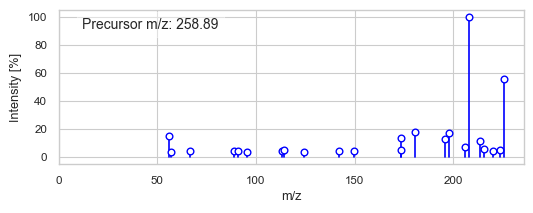

{'RT': 31.758257856,
 'charge': 1,
 'file_name': '202312_20_P09-Leaf-r1_1uL.mzML',
 'precursor_mz': 258.886535644531,
 'scan_number': 88}

In [110]:
msdata.at(1)

Indices in cluster: [506 509 510 516 519 521 533 674 745 746 749 750 752 756 759 764 769 946]


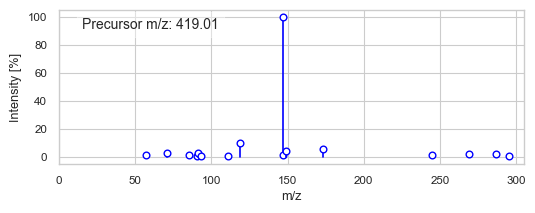

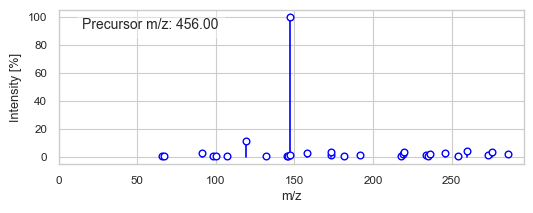

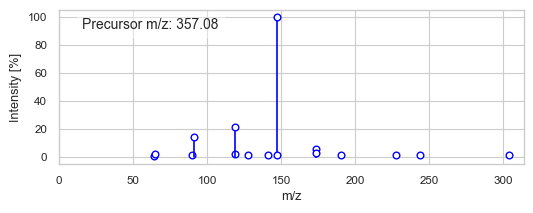

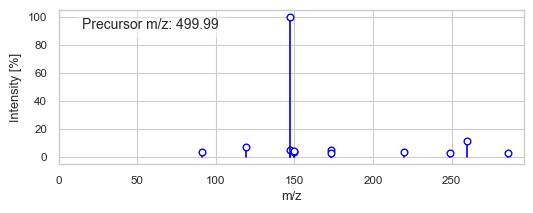

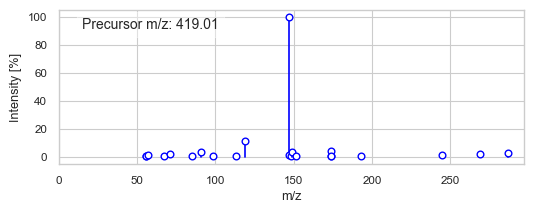

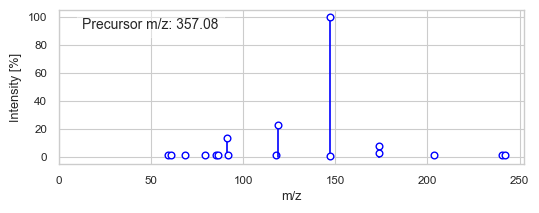

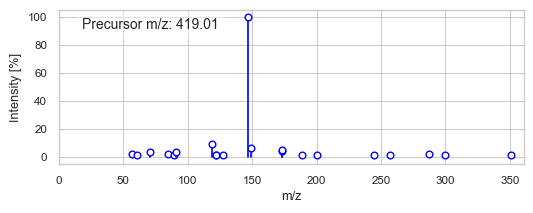

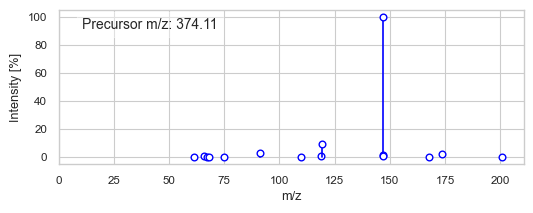

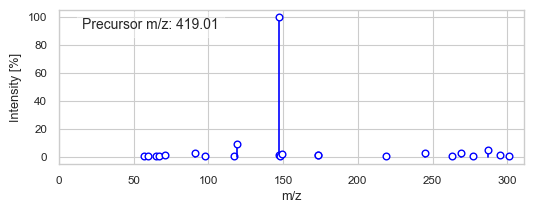

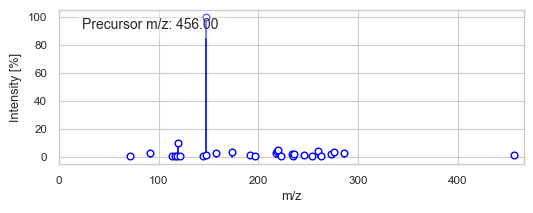

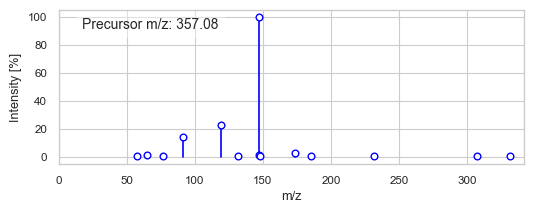

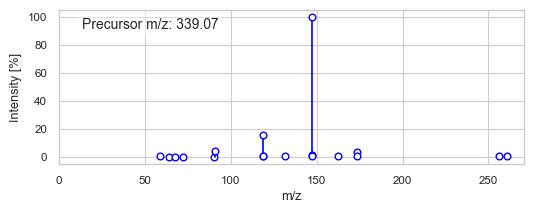

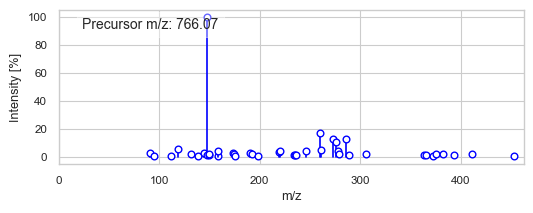

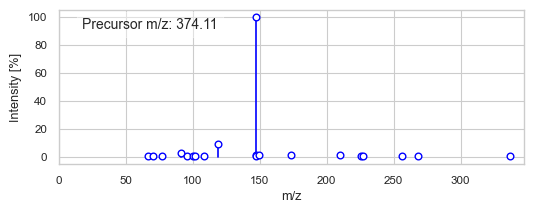

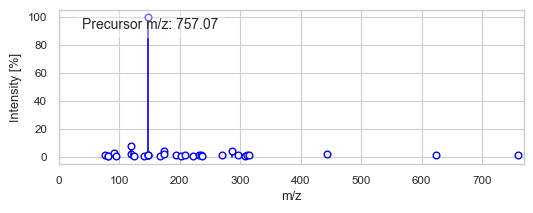

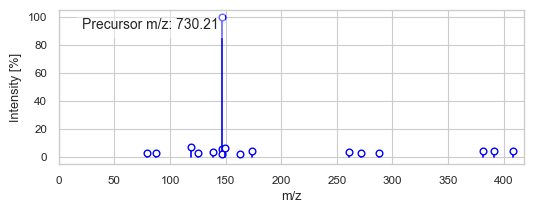

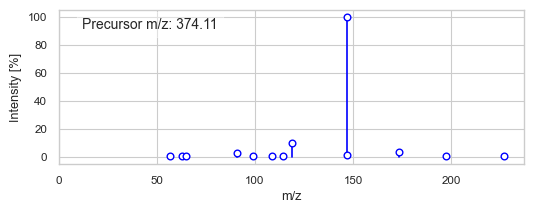

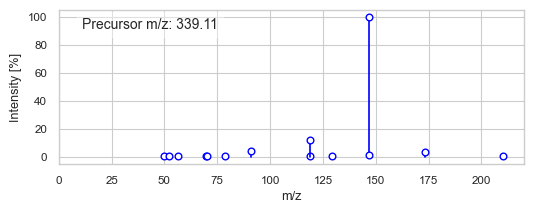

In [28]:
# pick a cluster of exactly 5 spectra
dup_hash = counts[counts == 18].index[0]
idxs = np.where(lshs == dup_hash)[0]

print("Indices in cluster:", idxs)

# plot the 5 spectra — cast each to Python int
for raw_i in idxs:
    i = int(raw_i)
    msdata.at(i, plot_mol=True)



In [29]:
# compute their pairwise modified–cosine
cos_sim = PeakListModifiedCosine()
sim_mat = cos_sim.compute_pairwise(
    specs    = spectra[idxs.astype(int)],            # also ensure int indexing here
    prec_mzs = msdata.get_values('precursor_mz')[idxs.astype(int)],
    avg      = False
)
print("Pairwise modified-cosine matrix:\n", sim_mat)

Pairwise modified-cosine matrix:
 [[1.         0.99338702 0.98487379 0.98713388 0.99946142 0.98338487
  0.99763788 0.99722651 0.99810648 0.99225012 0.98439416 0.99612256
  0.95393913 0.99670599 0.9956719  0.98857035 0.9975482  0.99719712]
 [0.99338702 1.         0.98416735 0.99143382 0.99380678 0.98201452
  0.99122889 0.9954144  0.99332333 0.99902758 0.98376763 0.9947475
  0.97242502 0.99517763 0.99251434 0.98608516 0.99549712 0.99557432]
 [0.98487379 0.98416735 1.         0.97390519 0.98696336 0.99777345
  0.98255397 0.9848863  0.98341211 0.98114621 0.9984594  0.99281865
  0.93878041 0.98472587 0.98170794 0.97141556 0.98645992 0.9904907 ]
 [0.98713388 0.99143382 0.97390519 1.         0.98716689 0.97162179
  0.98551091 0.98907638 0.98671188 0.99074336 0.972324   0.98601302
  0.97120132 0.9888678  0.98741266 0.98489845 0.98903964 0.98801304]
 [0.99946142 0.99380678 0.98696336 0.98716689 1.         0.98533596
  0.99756103 0.99745715 0.99862652 0.99243899 0.98662363 0.99695599
  0.9538871

In [21]:
def show_palette(cmap='nature', figsize=(6, 1.5)):
    """
    Display the full color palette defined in benchmark.utils.plots.

    Args:
        cmap (str): Name of the palette ('nature', 'plotly', etc.).
        figsize (tuple): Figure size in inches.
    """
    from benchmark.utils.plots import init_plotting, get_palette
    import matplotlib.pyplot as plt

    # initialize the style (so axes/frame/fonts match your project defaults)
    init_plotting(figsize=figsize, cmap=cmap)

    # grab the list of colors
    palette = get_palette(cmap)

    # plot each as a horizontal bar
    fig, ax = plt.subplots(figsize=figsize)
    for idx, color in enumerate(palette):
        ax.barh(0, 1, left=idx, color=color, height=0.8)

    # tidy up
    ax.set_xlim(0, len(palette))
    ax.set_yticks([])
    ax.set_xticks([i + 0.5 for i in range(len(palette))])
    ax.set_xticklabels([f"C{i+1}" for i in range(len(palette))], rotation=45)
    ax.set_frame_on(False)
    ax.set_title(f"Palette '{cmap}'", pad=6)

    plt.tight_layout()
    plt.show()

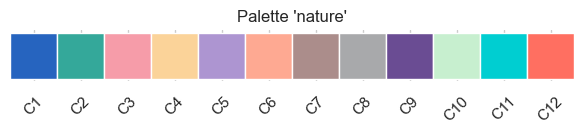

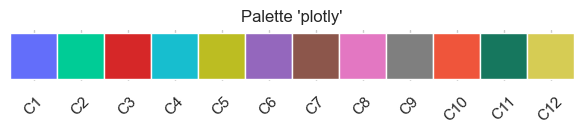

In [31]:
show_palette('nature')   # your “nature” palette
show_palette('plotly')   # the Plotly defaults


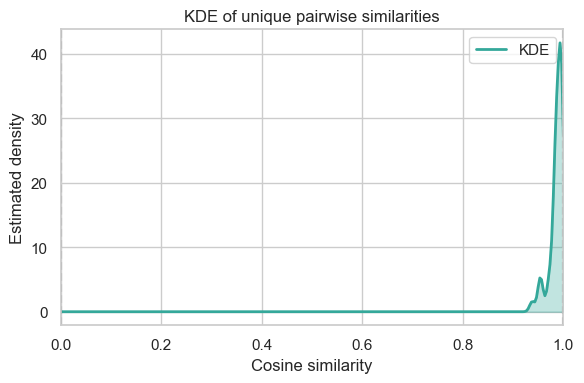

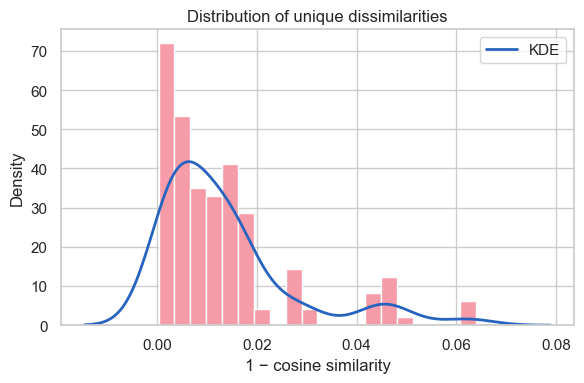

In [34]:
from benchmark.utils.plots import plot_similarity_kde, plot_dissimilarity_hist_kde

# Teal KDE
plot_similarity_kde(sim_mat, palette_idx=(1,))

# Pink histogram + lavender KDE
plot_dissimilarity_hist_kde(sim_mat, hist_idx=2, kde_idx=0)

## Saving dereplicated data

In [52]:
from pathlib import Path
import numpy as np
from dreams.utils.data import MSData
from dreams.algorithms.lsh import BatchedPeakListRandomProjection
from matchms.exporting import save_as_mgf

# 1) set up paths & LSH projector
RAW_DIR       = Path('/Users/macbook/CODE/DreaMS_MIMB/data/rawfiles')
mzml_path     = RAW_DIR / '202312_20_P09-Leaf-r1_1uL.mzML'
dedup_h5      = RAW_DIR / '202312_20_P09-Leaf-r1_1uL_dedup.hdf5'
dedup_mgf     = RAW_DIR / '202312_20_P09-Leaf-r1_1uL_dedup.mgf'

lsh_projector = BatchedPeakListRandomProjection(bin_step=0.5, n_hyperplanes=50)

# 2) load (or reuse cache) and compute hashes
if h5_path.exists():
    # load the already‐written HDF5 (no rewrite)
    msdata = MSData.from_hdf5(str(h5_path), in_mem=True) 
else:
    # first time: read .mzML, convert and cache to .hdf5
    msdata = MSData.from_mzml(str(mzml_path))
    
specs   = msdata.get_spectra()                        # shape: (N, 2, P)
hashes  = lsh_projector.compute(specs)                # (N,)

# 3) pick one representative index per hash
_, first_idxs = np.unique(hashes, return_index=True)  # first occurrence of each unique hash
keep_idxs     = np.sort(first_idxs)                   # sorted list of ints

# 4) write out a new HDF5 with only the deduped scans
msdata_dedup = msdata.form_subset(keep_idxs, out_pth=dedup_h5)

# # 5a) get a list of properly‐typed matchms Spectra
# spectra = msdata_dedup.to_matchms(progress_bar=True)
# 
# # 5b) write out the new deduplicated MGF
# save_as_mgf(spectra, str(dedup_mgf))
# print("Wrote deduped MGF to", dedup_mgf)

Loading dataset 202312_25_P09-Stem-r2_1uL into memory (4722 spectra)...



Computing LSHs: 100%|██████████| 4722/4722 [00:01<00:00, 2868.83it/s]


In [56]:
from pathlib import Path
from tqdm import tqdm
from dreams.utils.data import MSData
from dreams.algorithms.lsh import BatchedPeakListRandomProjection
from matchms.exporting import save_as_mgf
from matchms.importing import load_from_mgf

# 1) Set up paths & LSH projector
RAW_DIR       = Path('/Users/macbook/CODE/DreaMS_MIMB/data/rawfiles')
mzml_path     = RAW_DIR / '202312_20_P09-Leaf-r1_1uL.mzML'
h5_path       = mzml_path.with_suffix('.hdf5')
dedup_h5      = RAW_DIR / '202312_20_P09-Leaf-r1_1uL_dedup.hdf5'
dedup_mgf     = RAW_DIR / '202312_20_P09-Leaf-r1_1uL_dedup.mgf'

lsh_projector = BatchedPeakListRandomProjection(bin_step=0.5, n_hyperplanes=50)

# 2) Load (or cache) and compute LSH hashes
if h5_path.exists():
    msdata = MSData.from_hdf5(h5_path, in_mem=True)
else:
    msdata = MSData.from_mzml(mzml_path)
specs  = msdata.get_spectra()         # shape (N,2,P)
hashes = lsh_projector.compute(specs) # shape (N,)

# 3) Pick one representative index per unique hash
_, first_idxs = np.unique(hashes, return_index=True)
keep_idxs     = np.sort(first_idxs)

# 4) Build a new HDF5 with only the deduped scans
msdata_dedup = msdata.form_subset(keep_idxs, out_pth=dedup_h5)

# 5) Convert each to a matchms.Spectrum and save as MGF
spectra = []
for i in tqdm(range(len(msdata_dedup)), desc="Converting to matchms"):
    # spec_to_matchms returns a matchms.Spectrum for index i
    spectra.append(msdata_dedup.spec_to_matchms(i))

save_as_mgf(spectra, str(dedup_mgf))
print("Wrote deduped MGF to", dedup_mgf)

# 6) Reload the MGF and sanity-check
reloaded = list(load_from_mgf(str(dedup_mgf)))
print(f"Reloaded {len(reloaded)} spectra from {dedup_mgf}")
assert len(reloaded) == len(msdata_dedup), "Mismatch in number of spectra!"

Loading dataset 202312_20_P09-Leaf-r1_1uL into memory (5681 spectra)...



Computing LSHs: 100%|██████████| 5681/5681 [00:01<00:00, 2873.62it/s]

Converting to matchms:   0%|          | 0/4501 [00:00<?, ?it/s]


TypeError: MSData.at() got an unexpected keyword argument 'plot'

In [53]:
len(msdata_dedup)

3543

In [54]:
len(msdata)

4722

# HERE IMPORTANT

## To find interesting embeddings

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd

from dreams.utils.data import MSData
from dreams.algorithms.lsh import BatchedPeakListRandomProjection

# 1) paths
RAW_DIR   = Path("/…/data/rawfiles")
mzml_path = RAW_DIR / "202312_20_P09-Leaf-r1_1uL.mzML"
dedup_h5  = RAW_DIR / "202312_20_P09-Leaf-r1_1uL_dedup.hdf5"

# 2) load & compute LSH hashes
msdata = MSData.from_mzml(mzml_path)
specs   = msdata.get_spectra()
lshs    = BatchedPeakListRandomProjection(bin_step=0.5, n_hyperplanes=50).compute(specs)

# 3) build a little DataFrame to keep track of origin
df_map = pd.DataFrame({
    "orig_idx":    np.arange(len(lshs)),
    "file_name":   msdata.get_values("file_name"),
    "scan_number": msdata.get_values("scan_number"),
    "lsh":         lshs,
})

# 4) dedupe
_, first_idxs = np.unique(lshs, return_index=True)
keep_idxs     = np.sort(first_idxs)
msdata_dedup  = msdata.form_subset(keep_idxs, out_pth=dedup_h5)

# 5) restrict our map to just the ones we kept, and reset its index so it lines up with msdata_dedup
df_map_dedup = df_map.iloc[keep_idxs].reset_index(drop=True)

# 6) now you can compute whatever embeddings you like on msdata_dedup…
embs = get_embeddings(my_model, msdata_dedup)   # (N_dedup, D)

# 7) and if you find “embedding j” interesting:
j = 17
row = df_map_dedup.loc[j]
print(f"Embedding {j} → file {row.file_name}, scan {row.scan_number}")

## Load multiple files

In [58]:
# 2) Define your paths ----------------------------------

# directory containing your mzML files
mzml_dir = PROJECT_ROOT / "data" / "rawfiles"

In [59]:
# pick only the first 5 mzMLs for this demo
all_mzmls = sorted(mzml_dir.glob("*.mzML"))[2:7]

In [60]:
all_mzmls

[PosixPath('/Users/macbook/CODE/DreaMS_MIMB/data/rawfiles/202312_20_P09-Leaf-r1_1uL.mzML'),
 PosixPath('/Users/macbook/CODE/DreaMS_MIMB/data/rawfiles/202312_21_P09-Leaf-r2_1uL.mzML'),
 PosixPath('/Users/macbook/CODE/DreaMS_MIMB/data/rawfiles/202312_22_P09-Leaf-r3_1uL.mzML'),
 PosixPath('/Users/macbook/CODE/DreaMS_MIMB/data/rawfiles/202312_24_P09-Stem-r1_1uL.mzML'),
 PosixPath('/Users/macbook/CODE/DreaMS_MIMB/data/rawfiles/202312_25_P09-Stem-r2_1uL.mzML')]

In [61]:
# 3) Initialize LSH projector & results DataFrame -----------------
lsh_projector = BatchedPeakListRandomProjection(bin_step=0.5, n_hyperplanes=50)


In [62]:
df = pd.DataFrame()
for p in tqdm(all_mzmls, desc="Files"):
    print(f"Processing {p.name} …")
    h5_path = p.with_suffix(".hdf5")
    if h5_path.exists():
        # load the already‐written HDF5 (no rewrite)
        msdata = MSData.from_hdf5(str(h5_path), in_mem=True) 
    else:
        # first time: read .mzML, convert and cache to .hdf5
        msdata = MSData.from_mzml(str(p))

    hashes = lsh_projector.compute(msdata.get_spectra())
    df_part = pd.DataFrame({
        "file_name":   p.name,
        "scan_number": msdata.get_values("scan_number"),
        "lsh":         hashes
    })
    df = pd.concat([df, df_part], ignore_index=True)


Files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing 202312_20_P09-Leaf-r1_1uL.mzML …
Loading dataset 202312_20_P09-Leaf-r1_1uL into memory (5681 spectra)...




Computing LSHs:   0%|          | 0/5681 [00:00<?, ?it/s]

Computing LSHs:   6%|▌         | 320/5681 [00:00<00:01, 2927.19it/s]

Computing LSHs:  11%|█▏        | 640/5681 [00:00<00:01, 2873.08it/s]

Computing LSHs:  16%|█▋        | 928/5681 [00:00<00:01, 2855.41it/s]

Computing LSHs:  21%|██▏       | 1216/5681 [00:00<00:01, 2858.85it/s]

Computing LSHs:  26%|██▋       | 1504/5681 [00:00<00:01, 2858.29it/s]

Computing LSHs:  32%|███▏      | 1792/5681 [00:00<00:01, 2864.35it/s]

Computing LSHs:  37%|███▋      | 2080/5681 [00:00<00:01, 2869.19it/s]

Computing LSHs:  42%|████▏     | 2400/5681 [00:00<00:01, 2878.47it/s]

Computing LSHs:  47%|████▋     | 2688/5681 [00:00<00:01, 2878.12it/s]

Computing LSHs:  52%|█████▏    | 2976/5681 [00:01<00:00, 2872.52it/s]

Computing LSHs:  57%|█████▋    | 3264/5681 [00:01<00:00, 2862.17it/s]

Computing LSHs:  63%|██████▎   | 3552/5681 [00:01<00:00, 2850.13it/s]

Computing LSHs:  68%|██████▊   | 3840/5681 [00:01<00:00, 2847.50it/s]

Computing LSHs:  73%

Processing 202312_21_P09-Leaf-r2_1uL.mzML …
Loading dataset 202312_21_P09-Leaf-r2_1uL into memory (5570 spectra)...




Computing LSHs:   0%|          | 0/5570 [00:00<?, ?it/s]

Computing LSHs:   6%|▌         | 320/5570 [00:00<00:01, 2916.65it/s]

Computing LSHs:  11%|█▏        | 640/5570 [00:00<00:01, 2884.59it/s]

Computing LSHs:  17%|█▋        | 960/5570 [00:00<00:01, 2887.61it/s]

Computing LSHs:  23%|██▎       | 1280/5570 [00:00<00:01, 2891.62it/s]

Computing LSHs:  29%|██▊       | 1600/5570 [00:00<00:01, 2889.30it/s]

Computing LSHs:  34%|███▍      | 1920/5570 [00:00<00:01, 2878.04it/s]

Computing LSHs:  40%|███▉      | 2208/5570 [00:00<00:01, 2877.73it/s]

Computing LSHs:  45%|████▍     | 2496/5570 [00:00<00:01, 2874.44it/s]

Computing LSHs:  50%|████▉     | 2784/5570 [00:00<00:00, 2866.62it/s]

Computing LSHs:  55%|█████▌    | 3072/5570 [00:01<00:00, 2848.14it/s]

Computing LSHs:  60%|██████    | 3360/5570 [00:01<00:00, 2841.27it/s]

Computing LSHs:  65%|██████▌   | 3648/5570 [00:01<00:00, 2834.77it/s]

Computing LSHs:  71%|███████   | 3936/5570 [00:01<00:00, 2834.29it/s]

Computing LSHs:  76%

Processing 202312_22_P09-Leaf-r3_1uL.mzML …
Loading dataset 202312_22_P09-Leaf-r3_1uL into memory (6024 spectra)...




Computing LSHs:   0%|          | 0/6024 [00:00<?, ?it/s]

Computing LSHs:   5%|▌         | 320/6024 [00:00<00:01, 2890.80it/s]

Computing LSHs:  11%|█         | 640/6024 [00:00<00:01, 2861.89it/s]

Computing LSHs:  15%|█▌        | 928/6024 [00:00<00:01, 2864.63it/s]

Computing LSHs:  21%|██        | 1248/6024 [00:00<00:01, 2876.36it/s]

Computing LSHs:  25%|██▌       | 1536/6024 [00:00<00:01, 2870.93it/s]

Computing LSHs:  31%|███       | 1856/6024 [00:00<00:01, 2873.00it/s]

Computing LSHs:  36%|███▌      | 2144/6024 [00:00<00:01, 2870.83it/s]

Computing LSHs:  40%|████      | 2432/6024 [00:00<00:01, 2869.63it/s]

Computing LSHs:  46%|████▌     | 2752/6024 [00:00<00:01, 2875.00it/s]

Computing LSHs:  51%|█████     | 3072/6024 [00:01<00:01, 2879.12it/s]

Computing LSHs:  56%|█████▌    | 3360/6024 [00:01<00:00, 2870.40it/s]

Computing LSHs:  61%|██████    | 3648/6024 [00:01<00:00, 2861.81it/s]

Computing LSHs:  65%|██████▌   | 3936/6024 [00:01<00:00, 2855.17it/s]

Computing LSHs:  70%

Processing 202312_24_P09-Stem-r1_1uL.mzML …
Loading dataset 202312_24_P09-Stem-r1_1uL into memory (4230 spectra)...




Computing LSHs:   0%|          | 0/4230 [00:00<?, ?it/s]

Computing LSHs:   8%|▊         | 320/4230 [00:00<00:01, 2927.72it/s]

Computing LSHs:  15%|█▌        | 640/4230 [00:00<00:01, 2897.63it/s]

Computing LSHs:  23%|██▎       | 960/4230 [00:00<00:01, 2891.50it/s]

Computing LSHs:  30%|███       | 1280/4230 [00:00<00:01, 2893.25it/s]

Computing LSHs:  38%|███▊      | 1600/4230 [00:00<00:00, 2892.95it/s]

Computing LSHs:  45%|████▌     | 1920/4230 [00:00<00:00, 2894.20it/s]

Computing LSHs:  53%|█████▎    | 2240/4230 [00:00<00:00, 2886.51it/s]

Computing LSHs:  61%|██████    | 2560/4230 [00:00<00:00, 2886.22it/s]

Computing LSHs:  68%|██████▊   | 2880/4230 [00:00<00:00, 2886.86it/s]

Computing LSHs:  76%|███████▌  | 3200/4230 [00:01<00:00, 2879.77it/s]

Computing LSHs:  82%|████████▏ | 3488/4230 [00:01<00:00, 2869.58it/s]

Computing LSHs:  89%|████████▉ | 3776/4230 [00:01<00:00, 2859.07it/s]

Computing LSHs: 100%|██████████| 4230/4230 [00:01<00:00, 2874.01it/s]

Files:  80%|████████

Processing 202312_25_P09-Stem-r2_1uL.mzML …
Loading dataset 202312_25_P09-Stem-r2_1uL into memory (4722 spectra)...




Computing LSHs:   0%|          | 0/4722 [00:00<?, ?it/s]

Computing LSHs:   7%|▋         | 320/4722 [00:00<00:01, 2905.76it/s]

Computing LSHs:  14%|█▎        | 640/4722 [00:00<00:01, 2884.10it/s]

Computing LSHs:  20%|██        | 960/4722 [00:00<00:01, 2885.05it/s]

Computing LSHs:  27%|██▋       | 1280/4722 [00:00<00:01, 2883.25it/s]

Computing LSHs:  34%|███▍      | 1600/4722 [00:00<00:01, 2886.99it/s]

Computing LSHs:  41%|████      | 1920/4722 [00:00<00:00, 2886.02it/s]

Computing LSHs:  47%|████▋     | 2240/4722 [00:00<00:00, 2885.89it/s]

Computing LSHs:  54%|█████▍    | 2560/4722 [00:00<00:00, 2884.26it/s]

Computing LSHs:  61%|██████    | 2880/4722 [00:00<00:00, 2883.85it/s]

Computing LSHs:  68%|██████▊   | 3200/4722 [00:01<00:00, 2882.73it/s]

Computing LSHs:  75%|███████▍  | 3520/4722 [00:01<00:00, 2873.09it/s]

Computing LSHs:  81%|████████  | 3808/4722 [00:01<00:00, 2856.83it/s]

Computing LSHs:  87%|████████▋ | 4096/4722 [00:01<00:00, 2850.67it/s]

Computing LSHs:  93%

In [63]:
print(msdata.columns())

['RT', 'charge', 'file_name', 'precursor_mz', 'scan_number', 'spectrum']


In [64]:
msdata.get_values('charge')

array([1, 0, 1, ..., 0, 0, 1])

In [65]:
# 5) Inspect & deduplicate -----------------------------------------
print(f"Total spectra across all files: {len(df)}")
df_unique = df.drop_duplicates(subset=["lsh"])
print(f"Unique LSH clusters (one per hash): {len(df_unique)}")

Total spectra across all files: 26227
Unique LSH clusters (one per hash): 17914


In [66]:
df.head()

,file_name,scan_number,lsh
0,202312_20_P09-Leaf-r1_1uL.mzML,86,b'de2e0f074dee67d746112ca495fd0b2674eb3af7bfab...
1,202312_20_P09-Leaf-r1_1uL.mzML,88,b'786a202663fa5e0a28a584694ad780c327417a5905f0...
2,202312_20_P09-Leaf-r1_1uL.mzML,89,b'9c88e20ee285651e037473163d04baa14cd110ec5949...
3,202312_20_P09-Leaf-r1_1uL.mzML,90,b'6757110d0419c9086b5083a1548356fbf51a03274779...
4,202312_20_P09-Leaf-r1_1uL.mzML,91,b'f76c0fbc0106c6585724af5c0deaf21a6064ab267984...


In [67]:
df_unique.head()

,file_name,scan_number,lsh
0,202312_20_P09-Leaf-r1_1uL.mzML,86,b'de2e0f074dee67d746112ca495fd0b2674eb3af7bfab...
1,202312_20_P09-Leaf-r1_1uL.mzML,88,b'786a202663fa5e0a28a584694ad780c327417a5905f0...
2,202312_20_P09-Leaf-r1_1uL.mzML,89,b'9c88e20ee285651e037473163d04baa14cd110ec5949...
3,202312_20_P09-Leaf-r1_1uL.mzML,90,b'6757110d0419c9086b5083a1548356fbf51a03274779...
4,202312_20_P09-Leaf-r1_1uL.mzML,91,b'f76c0fbc0106c6585724af5c0deaf21a6064ab267984...


In [47]:
# 6) (Optional) Save your cleaned library --------------------------
# To write out one representative spectrum per cluster, you could:

from matchms.importing import load_from_mzml
from matchms.exporting import save_as_mgf

reps = []
for _, row in df_unique.iterrows():
    p = mzml_dir / row["file_name"]
    msdata = MSData.from_mzml(p)
    specs = msdata.get_spectra()           # array shape (n,2,peaks)
    # load full matchms.Spectrum list via matchms.importing.load_from_mzml if desired
    reps.append( load_from_mzml(str(p))[ row["scan_number"] - 1 ] )

save_as_mgf(reps, str(PROJECT_ROOT/"data"/"rawfiles"/"deduped_library.mgf"))

Loading dataset 202312_20_P09-Leaf-r1_1uL into memory (5681 spectra)...


TypeError: 'generator' object is not subscriptable

# Multiple files but saved

In [72]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

# DreaMS / LSH imports
from dreams.utils.data       import MSData
from dreams.algorithms.lsh   import BatchedPeakListRandomProjection
from benchmark.models.lit_dreams_module import LitDreamsClassifier


raw_dir = PROJECT_ROOT / "data" / "rawfiles"

files = [
    raw_dir / "202312_20_P09-Leaf-r1_1uL.mzML",
    raw_dir / "202312_21_P09-Leaf-r2_1uL.mzML",
    raw_dir / "202312_22_P09-Leaf-r3_1uL.mzML",
    raw_dir / "202312_24_P09-Stem-r1_1uL.mzML",
    raw_dir / "202312_25_P09-Stem-r2_1uL.mzML",
]

# 2) instantiate one LSH projector (reuse for *all* files!)
lsh_proj = BatchedPeakListRandomProjection(bin_step=0.5, n_hyperplanes=50)



➡️  Processing 202312_20_P09-Leaf-r1_1uL.mzML
Loading dataset 202312_20_P09-Leaf-r1_1uL into memory (5681 spectra)...
['RT', 'charge', 'file_name', 'precursor_mz', 'scan_number', 'spectrum']


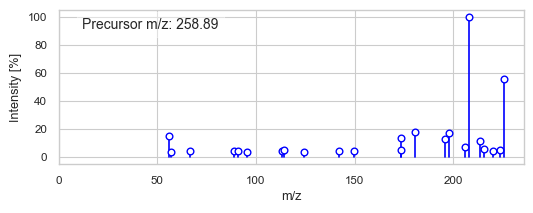


Computing LSHs: 100%|██████████| 5681/5681 [00:01<00:00, 2851.69it/s]


➡️  Processing 202312_21_P09-Leaf-r2_1uL.mzML
Loading dataset 202312_21_P09-Leaf-r2_1uL into memory (5570 spectra)...
['RT', 'charge', 'file_name', 'precursor_mz', 'scan_number', 'spectrum']


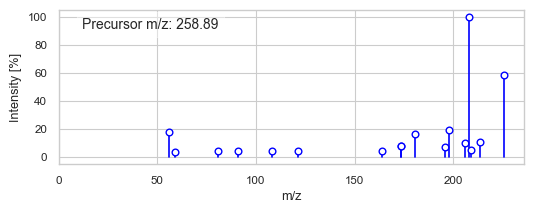


Computing LSHs: 100%|██████████| 5570/5570 [00:01<00:00, 2865.42it/s]


➡️  Processing 202312_22_P09-Leaf-r3_1uL.mzML
Loading dataset 202312_22_P09-Leaf-r3_1uL into memory (6024 spectra)...
['RT', 'charge', 'file_name', 'precursor_mz', 'scan_number', 'spectrum']


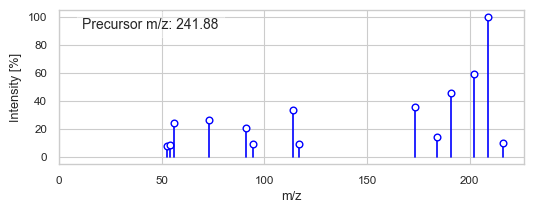


Computing LSHs: 100%|██████████| 6024/6024 [00:02<00:00, 2884.96it/s]


➡️  Processing 202312_24_P09-Stem-r1_1uL.mzML
Loading dataset 202312_24_P09-Stem-r1_1uL into memory (4230 spectra)...
['RT', 'charge', 'file_name', 'precursor_mz', 'scan_number', 'spectrum']


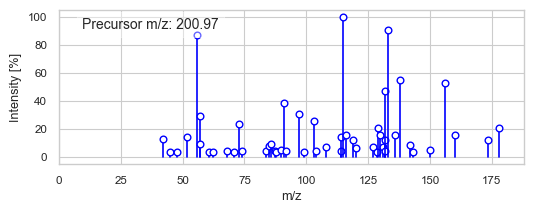


Computing LSHs: 100%|██████████| 4230/4230 [00:01<00:00, 2861.60it/s]


➡️  Processing 202312_25_P09-Stem-r2_1uL.mzML
Loading dataset 202312_25_P09-Stem-r2_1uL into memory (4722 spectra)...
['RT', 'charge', 'file_name', 'precursor_mz', 'scan_number', 'spectrum']


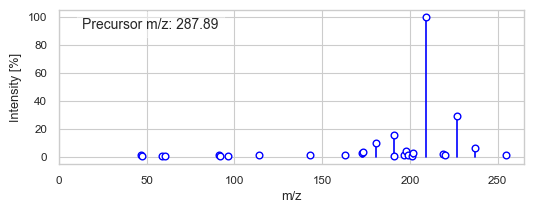


Computing LSHs: 100%|██████████| 4722/4722 [00:01<00:00, 2870.39it/s]


In [98]:
# 3) loop: read (or load cache) → LSH → dedupe → write per-file hdf5 & collect maps
# prepare collections
per_file_h5 = []
maps        = []
for p in files:
    print(f"➡️  Processing {p.name}")

    #--- cache check: if .hdf5 exists, load it; otherwise parse .mzML → .hdf5 ---
    h5_cache = p.with_suffix(".hdf5")
    if h5_cache.exists():
        ms = MSData.from_hdf5(h5_cache, in_mem=True)
    else:
        ms = MSData.from_mzml(p, in_mem=True)
    print(ms.columns())
    # compute LSH hashes
    specs  = ms.get_spectra()               # shape: (N,2,P)
    hashes = lsh_proj.compute(specs)        # shape: (N,)

    # keep only first occurrence of each hash
    _, keep = np.unique(hashes, return_index=True)
    keep     = np.sort(keep)                # restore ascending scan order

    # write out a per-file dedup HDF5
    out_h5    = p.with_name(p.stem + "_dedup.hdf5")
    ms_dedup  = ms.form_subset(keep, out_pth=out_h5)
    per_file_h5.append(out_h5)

    # record local‐to‐global mapping
    maps.append(pd.DataFrame({
        "dataset":   ms_dedup.get_values("file_name"),
        "scan_number": ms_dedup.get_values("scan_number"),
        "local_idx":   np.arange(len(ms_dedup)),
    }))

In [ ]:
import logging

# set up a logger (prints INFO+ messages to stdout)
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("msdata_merge")

# now call merge and pass the logger in
merged_h5 = raw_dir / "all_5_dedup.hdf5"


In [78]:
# only merge the columns you actually have
cols_to_merge = [
    "RT",
    "charge",
    "file_name",
    "precursor_mz",
    "scan_number",
    "spectrum",
]

ms_all = MSData.merge(
    pths             = per_file_h5,
    out_pth          = merged_h5,
    cols             = cols_to_merge,     # <- explicitly list only these
    add_dataset_col  = True,              # adds a “dataset” column = stem of each file
    in_mem           = True,
    logger           = logger,
)

INFO:msdata_merge:Using HDF5_USE_FILE_LOCKING=FALSE.
INFO:msdata_merge:Truncation spectra to 128 highest peaks (max num. peaks among pths datasets).

Merging hdfs:   0%|          | 0/5 [00:00<?, ?it/s]INFO:msdata_merge:Appending 1th / 5 hdf5 (4501 samples) file to /Users/macbook/CODE/DreaMS_MIMB/data/rawfiles/all_5_dedup.hdf5.
INFO:msdata_merge:Appending 2th / 5 hdf5 (4449 samples) file to /Users/macbook/CODE/DreaMS_MIMB/data/rawfiles/all_5_dedup.hdf5.
INFO:msdata_merge:Appending 3th / 5 hdf5 (4923 samples) file to /Users/macbook/CODE/DreaMS_MIMB/data/rawfiles/all_5_dedup.hdf5.
INFO:msdata_merge:Appending 4th / 5 hdf5 (3087 samples) file to /Users/macbook/CODE/DreaMS_MIMB/data/rawfiles/all_5_dedup.hdf5.

Merging hdfs: 100%|██████████| 5/5 [00:00<00:00, 38.55it/s]


Loading dataset all_5_dedup into memory (20503 spectra)...


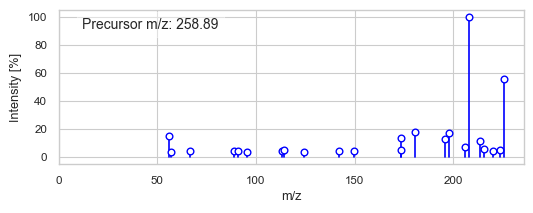

{'RT': 31.758257856,
 'charge': 1,
 'dataset': '202312_20_P09-Leaf-r1_1uL_dedup',
 'file_name': '202312_20_P09-Leaf-r1_1uL.mzML',
 'precursor_mz': 258.886535644531,
 'scan_number': 88}

In [97]:
ms_all.at(1)

In [94]:
ms_all.get_values("dataset", 1)

'202312_20_P09-Leaf-r1_1uL_dedup'

In [83]:
# build DataFrame mapping each merged row back to its file & scan
df_all = pd.DataFrame({
    "dataset":     ms_all.get_values("dataset"),
    "scan_number": ms_all.get_values("scan_number"),
})
df_all["global_idx"] = np.arange(len(ms_all))


In [90]:
# 6) concatenate your per-file maps into one big map DataFrame
maps_df = pd.concat(maps, ignore_index=True)

In [91]:
maps_df.columns

Index(['dataset', 'scan_number', 'local_idx'], dtype='object')

In [92]:
len(maps_df)

20503

In [95]:
df_all.head()

,dataset,scan_number,global_idx
0,b'202312_20_P09-Leaf-r1_1uL_dedup',86,0
1,b'202312_20_P09-Leaf-r1_1uL_dedup',88,1
2,b'202312_20_P09-Leaf-r1_1uL_dedup',89,2
3,b'202312_20_P09-Leaf-r1_1uL_dedup',90,3
4,b'202312_20_P09-Leaf-r1_1uL_dedup',91,4


In [96]:
maps_df.head()

,dataset,scan_number,local_idx
0,202312_20_P09-Leaf-r1_1uL.mzML,86,0
1,202312_20_P09-Leaf-r1_1uL.mzML,88,1
2,202312_20_P09-Leaf-r1_1uL.mzML,89,2
3,202312_20_P09-Leaf-r1_1uL.mzML,90,3
4,202312_20_P09-Leaf-r1_1uL.mzML,91,4


In [93]:
# 7) now join them—this aligns local_idx to global_idx
df_lookup = (
    df_all
    .merge(maps_df, on=["dataset","scan_number"], how="left")
    # columns now: dataset, scan_number, global_idx, local_idx
)

# sanity check
assert not df_lookup["local_idx"].isnull().any()

AssertionError: 

In [ ]:




# 5) compute DreaMS embeddings on the merged spectra ------------------------
# load your finetuned LightningModule
lit = LitDreamsClassifier.load_from_checkpoint("dreams_chlorine_finetuned.ckpt")
lit.eval()
device = torch.device("cpu")

with torch.no_grad():
    specs_all = torch.from_numpy(ms_all.get_spectra()).to(device)  # (M,2,P)
    embs_full = lit.model.spec_encoder(specs_all)                  # (M,Seq,D)
    # take the [CLS]-like 1st token
    cls_embs  = embs_full[:, 0, :].cpu().numpy()                   # (M,D)

# save embeddings for downstream
np.save(raw_dir / "all_5_dedup_embeddings.npy", cls_embs)

# 6) now df_all and cls_embs line up perfectly by `global_idx` --------------
# e.g. to inspect the 10th embedding:
i = 10
print("→ came from:", df_all.loc[i, ["dataset","scan_number"]])
print("→ embedding vector (first 5 dims):", cls_embs[i,:5])